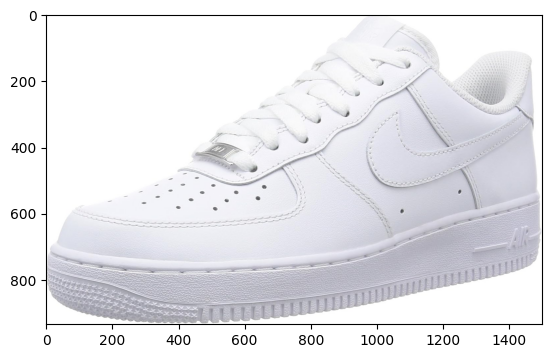

Created a chunk of size 869, which is longer than the specified 20
Created a chunk of size 588, which is longer than the specified 20
Created a chunk of size 654, which is longer than the specified 20
Created a chunk of size 594, which is longer than the specified 20
Created a chunk of size 588, which is longer than the specified 20
Created a chunk of size 660, which is longer than the specified 20
Created a chunk of size 516, which is longer than the specified 20
Created a chunk of size 528, which is longer than the specified 20


Based on the provided image, the Nike shoe that appears to be an Air Force 1, is likely a classic design. Here's a description:

- The shoe has a predominantly white upper, which suggests that the specific colorway is either "White" or "Briscoe White".
- The shoe features a low-cut design with a round toe cap.
- The Nike swoosh logo on the side is prominent and appears to be black.
- A black or dark-colored sole matches the upper's lacing and other trim accents.
- It seems that there is a minimalistic approach with the Air Force 1 design. The overall style of the shoe could be the basic or minimalist version that does not have many color blocking or branding pattern adjustments.

Please note, without access to a live source, I'm making an educated guess.


c:\Users\hp\Desktop\kunal_repo\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\hp\AppData\Local\Temp\ipykernel_10008\424086931.py:84: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(image_description)


In [1]:
import os
import requests
from PIL import Image
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain_community.document_loaders import TextLoader
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from dotenv import load_dotenv
from groq import Groq

# Load environment variables
load_dotenv()

# API Keys
grok_api_key = os.getenv("GROK_API_KEY")
HF_TOKEN = os.getenv("HF_TOKEN")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

def load_model(model_name):
    if model_name == "Gemma2":
        llm = ChatGroq(model="Gemma2-9b-It", groq_api_key=grok_api_key)
    else:
        llm = ChatGroq(model="llama-3.2-11b-vision-preview", groq_api_key=grok_api_key)
    return llm

# Model initialization
model_text = load_model("Gemma2")
model_vision = load_model("llama-3.2-11b-vision-preview")

def get_image(url, filename, extension):
    if not os.path.exists('content'):
        os.makedirs('content')
    content = requests.get(url).content
    file_path = f'content/{filename}.{extension}'
    with open(file_path, 'wb') as f:
        f.write(content)
    image = Image.open(file_path)
    return image

# Image URL
image_url = "https://images-cdn.ubuy.co.in/64ada0cffc64d6627d002728-nike-unisex-adult-air-force-1.jpg"
image = get_image(image_url, "nike-shoes", "png")
plt.imshow(image)
plt.show()

# Process the image through the vision model
prompt = "Describe this Nike shoe."
client = Groq(api_key=grok_api_key)
completion = client.chat.completions.create(
    model="llama-3.2-11b-vision-preview",
    messages=[
        {"role": "user", "content": prompt},
        {"role": "user", "content": image_url}
    ],
    temperature=1,
    max_completion_tokens=1024,
    top_p=1,
    stream=False,
    stop=None,
)
image_description = completion.choices[0].message.content
print(image_description)

# Load text data and process
loader = TextLoader("content/nike_shoes.txt")
text = loader.load()[0].page_content
from langchain.text_splitter import CharacterTextSplitter

def get_text_chunks_langchain(text):
    text_splitter = CharacterTextSplitter(chunk_size=20, chunk_overlap=10)
    docs = [Document(page_content=x) for x in text_splitter.split_text(text)]
    return docs

docs = get_text_chunks_langchain(text)
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(docs, embedding=embeddings)
retriever = vectorstore.as_retriever()

# Use get_relevant_documents method to retrieve relevant documents using the image description
retrieved_docs = retriever.get_relevant_documents(image_description)

